# Time Series Exercise - Solutions

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [52]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

** Check out the head of the dataframe**

In [53]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [54]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

In [ ]:
milk.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 3 months of data is the test set, with everything before it is the training. **

In [56]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [57]:
train_set = milk.head(156)

In [58]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaler = MinMaxScaler()

In [61]:
train_scaled = scaler.fit_transform(train_set)

In [62]:
test_scaled = scaler.transform(test_set)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [63]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)

In [64]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

** Import TensorFlow **

In [65]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [66]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [67]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [68]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [69]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

ValueError: Variable rnn/output_projection_wrapper/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Users\anonymous\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Users\anonymous\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\anonymous\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)


### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [ ]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [ ]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [ ]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [ ]:
test_set

** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session

### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)

** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

** Show the result of the predictions. **

In [ ]:
train_seed

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [ ]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [ ]:
test_set['Generated'] = results

** View the test_set dataframe. **

In [ ]:
test_set

** Plot out the two columns for comparison. **

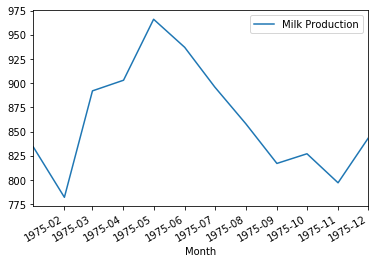

In [70]:
test_set.plot()

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!